# `Практикум по программированию на языке Python`

## `Рекуррентные Нейронные Сети. Dropout. LM`

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

# `Часть 0. Загрузка и предобработка данных (1 балл)`

## `Рекомендуемые гиперпараметры`

In [1]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

dataset: [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## `Загрузка и предобработка данных`

In [2]:
! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-04-27 17:06:46--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.9MB/s    in 8.9s    

2023-04-27 17:06:56 (9.05 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
! mkdir aclImdb
! tar -xf aclImdb_v1.tar.gz

In [ ]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [4]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [2]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('stopwords')

import regex
import numpy as np
from time import time

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /home/riot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Убираем часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [6]:
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

Функция для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`, ...)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [7]:
def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    text = text.lower()
    text = regex.sub(r'<[a-zA-Z0-9/ ]+>', "", text)
    text = regex.sub(r'[^a-z\s]', "", text)
    return [t for t in text.split() if not t in STOPWORDS]

In [ ]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь создадим словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab` и фабрика для создания таких классов `torchtext.vocab.vocab`.

In [ ]:
torchtext.vocab.vocab??

In [8]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами зарезервируем два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [ ]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

In [ ]:
vocab = torchtext.vocab.vocab(counter, specials=specials)

In [ ]:
vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

Создаём обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от $1$ до $10$. Для удобства, вычтите $1$, чтобы рейтинг был от $0$ до $9$

In [9]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos>
        :param bool pad_eos: If True pad sequence at the end with <eos>
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))
            

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        rating_pattern = regex.compile(r'_(?P<rating>[0-9]+).txt')
        for path in self.negative_paths + self.positive_paths:
            with open(path) as file_obj:
                txt = file_obj.read()
                self.texts.append(txt)
                result = rating_pattern.search(path)
                rating = int(result.group('rating')) - 1
                self.ratings.append(rating)
                token = tokenize(txt)
                token = token[:self.max_len]
                token = vocab.lookup_indices(token)
                if self.pad_sos:
                    token = [self.sos_id] + (token if len(token) < self.max_len else token[:self.max_len - 1])
                if self.pad_eos:
                    token = (token if len(token) < self.max_len else token[:self.max_len - 1]) + [self.eos_id]
                self.tokens.append(token)

                
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.Tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.Tensor(dtype=torch.long): rating of the text
                'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.Tensor(dtype=torch.long): number of tokens
            }
        """
        return {
                'text': self.texts[idx],
                'label': torch.tensor(self.labels[idx], dtype=torch.long),
                'rating': torch.tensor(self.ratings[idx], dtype=torch.long),
                'tokens': torch.tensor(self.tokens[idx], dtype=torch.long),
                'tokens_len': torch.tensor(len(self.tokens[idx]), dtype=torch.long)
            }

    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        return len(self.texts)

Создадим датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [ ]:
test_dataset = LargeMovieReviewDataset(test_data_path, vocab, max_length)
train_dataset = LargeMovieReviewDataset(train_data_path, vocab, max_length)

Посмотрим, как выглядит объект в датасете:

In [ ]:
test_dataset[0]

{'text': "This would have to rate as one of the worst films of all time. The film screened at the Italian Film Festival in Melbourne, Australia. After the screening, not only did I want my money refunded, I wanted the 1.5 wasted hours of my life back too. I have a very broad tolerance level when it comes to the indulgences of some European film-making, but this is one of those films that is selected for festivals based on the reputation of the filmmaker alone. This film is proof that while such selections may satisfy the egos of the film-maker and the selection panel, there is absolutely no joy for the audience. There is no character development whatsoever, the plot is a garbled mess, the style is nonsensical, the shot selection is appalling, and the editing is worse. By the end of the first reel, you'll wonder if you walked into the wrong cinema, and by the end of the third reel, you'll be begging to be put out of your misery. This film is an abomination.",
 'label': tensor(0),
 'rati

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` — число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [ ]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [10]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.Tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.Tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.Tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    return {
        "ratings": torch.tensor([obj["rating"] for obj in batch]),
        "labels": torch.tensor([obj["label"] for obj in batch]),
        "texts": [obj["text"] for obj in batch],
        "tokens": torch.nn.utils.rnn.pad_sequence([obj["tokens"] for obj in batch],
                                                  batch_first=batch_first, padding_value=padding_value),
        "tokens_lens": torch.tensor([obj["tokens_len"] for obj in batch])
    }

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [ ]:
padding_value = vocab.lookup_indices(["<pad>"])[0]
mycollate_fn = partial(collate_fn, padding_value=padding_value, batch_first=False)

test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=0, shuffle=True, collate_fn=mycollate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True, collate_fn=mycollate_fn)

In [ ]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 1, 1, 0, 0, 0]),
 tensor([1, 0, 0, 9, 9, 1, 1, 3]),
 tensor([[ 3350,   196,   631,  ...,   750,     7,   873],
         [ 3260,   730,  4375,  ...,  1243,   895,   342],
         [ 1086,   534,  1382,  ...,     4,  1552,  6281],
         ...,
         [    0,     0,     0,  ...,  1983,  2426,     0],
         [    0,     0,     0,  ...,   499,  1000,     0],
         [    0,     0,     0,  ...,   905, 20730,     0]]),
 tensor([112,  61,  78, 200,  60, 200, 200,  96]))

# `Часть 1. Классификация текстов`

## `Сборка и обучение RNN в pytorch`

Создадим переменные для device-agnostic кода:

In [11]:
dtype, device, cuda_device_id = torch.float32, None, (0 if torch.cuda.is_available() else None)
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-эмбеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

In [12]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        self.word_embeddings = torch.nn.Embedding(len(vocab), self.embedding_dim, padding_idx=vocab.lookup_indices(["<pad>"])[0])
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        self.output = torch.nn.Linear(self.hidden_dim, output_size)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.Tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """

        embeddings = self.word_embeddings(tokens)
        # батч имеет размерность (L, N, emb_dim)

        h, c = self.rnn(embeddings)
        # h имеет размерность (L, N, hidden_dim)
        # x = torch.stack([h[tokens_lens[i] - 1, i, :] for i in range(len(tokens_lens))])  # mistaken
        x = h[tokens_lens - 1, torch.arange(len(tokens_lens)), :]  # right (faster)

        return self.output(x)


[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Напишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [13]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        tokens = data["tokens"].to(device)
        tokens_lens = data["tokens_lens"].to(device)
        ratings = data["ratings"].to(device)

        outputs = model(tokens, tokens_lens)
        loss = loss_fn(outputs, ratings)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            tokens = data["tokens"].to(device)
            tokens_lens = data["tokens_lens"].to(device)
            ratings = data["ratings"].to(device)

            outputs = model(tokens, tokens_lens)
            loss = loss_fn(outputs, ratings)
            total_loss += loss * len(outputs)
            total_accuracy += (outputs.argmax(dim=1) == ratings).float().sum()

    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

In [ ]:
pure_time = time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
pure_time = time() - pure_time
print("Time:", pure_time)

Epoch: 1/15. Loss (Train/Test): 1.888/1.916. Accuracy (Train/Test): 0.308/0.309
Epoch: 2/15. Loss (Train/Test): 1.545/1.674. Accuracy (Train/Test): 0.403/0.364
Epoch: 3/15. Loss (Train/Test): 1.364/1.636. Accuracy (Train/Test): 0.472/0.358
Epoch: 4/15. Loss (Train/Test): 1.149/1.626. Accuracy (Train/Test): 0.550/0.383
Epoch: 5/15. Loss (Train/Test): 0.948/1.739. Accuracy (Train/Test): 0.653/0.369
Epoch: 6/15. Loss (Train/Test): 0.716/1.971. Accuracy (Train/Test): 0.744/0.367
Epoch: 7/15. Loss (Train/Test): 0.524/2.157. Accuracy (Train/Test): 0.835/0.353
Epoch: 8/15. Loss (Train/Test): 0.357/2.509. Accuracy (Train/Test): 0.894/0.346
Epoch: 9/15. Loss (Train/Test): 0.213/2.869. Accuracy (Train/Test): 0.944/0.339
Epoch: 10/15. Loss (Train/Test): 0.142/3.242. Accuracy (Train/Test): 0.966/0.320
Epoch: 11/15. Loss (Train/Test): 0.077/3.586. Accuracy (Train/Test): 0.983/0.334
Epoch: 12/15. Loss (Train/Test): 0.055/3.957. Accuracy (Train/Test): 0.988/0.323
Epoch: 13/15. Loss (Train/Test): 0.03

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют *L2-регуляризацию* и *дропаут*.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## `Реализация дропаута по статье Гала и Гарамани. Variational Dropout`

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Напишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

In [14]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    return some_existing_tensor.new_zeros((num_objects, hidden_size)), \
           some_existing_tensor.new_zeros((num_objects, hidden_size))

In [15]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    if p is None:
        return some_existing_tensor.new_ones((input_size, )), some_existing_tensor.new_ones((hidden_size, ))
    if is_training:
        probs_inp = some_existing_tensor.new_full((input_size, ), 1 - p)
        probs_hid = some_existing_tensor.new_full((hidden_size, ), 1 - p)
        return torch.bernoulli(probs_inp), torch.bernoulli(probs_hid)
    else:
        return some_existing_tensor.new_full((input_size, ), 1 - p), some_existing_tensor.new_full((hidden_size, ), 1 - p)

In [16]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # x shape is (L, N, input_size) where N is num of batches
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        # Gen masks for input and hidden state
        mask_x, mask_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
        
        output = []
        h_t, c_t = h_0, c_0
        for t in range(x.shape[0]):
            h_t, c_t = self.rnn_cell(x[t] * mask_x, (h_t * mask_h, c_t))
            output.append(h_t)

        return torch.stack(output), (h_t, c_t)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
off_dropout_time = time() 
train_losses_off_dropout, train_accuracies_off_dropout, test_losses_off_dropout, test_accuracies_off_dropout = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
off_dropout_time = time() - off_dropout_time
print("Time:", off_dropout_time)

Epoch: 1/15. Loss (Train/Test): 1.954/1.982. Accuracy (Train/Test): 0.263/0.264
Epoch: 2/15. Loss (Train/Test): 1.502/1.659. Accuracy (Train/Test): 0.404/0.365
Epoch: 3/15. Loss (Train/Test): 1.325/1.615. Accuracy (Train/Test): 0.472/0.374
Epoch: 4/15. Loss (Train/Test): 1.150/1.628. Accuracy (Train/Test): 0.548/0.385
Epoch: 5/15. Loss (Train/Test): 0.958/1.737. Accuracy (Train/Test): 0.642/0.367
Epoch: 6/15. Loss (Train/Test): 0.742/1.891. Accuracy (Train/Test): 0.748/0.359
Epoch: 7/15. Loss (Train/Test): 0.552/2.154. Accuracy (Train/Test): 0.819/0.354
Epoch: 8/15. Loss (Train/Test): 0.369/2.515. Accuracy (Train/Test): 0.889/0.341
Epoch: 9/15. Loss (Train/Test): 0.233/2.876. Accuracy (Train/Test): 0.935/0.335
Epoch: 10/15. Loss (Train/Test): 0.152/3.270. Accuracy (Train/Test): 0.958/0.341
Epoch: 11/15. Loss (Train/Test): 0.091/3.617. Accuracy (Train/Test): 0.977/0.340
Epoch: 12/15. Loss (Train/Test): 0.060/3.834. Accuracy (Train/Test): 0.987/0.328
Epoch: 13/15. Loss (Train/Test): 0.04

Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
dropout_25_time = time() 
train_losses_25_dropout, train_accuracies_25_dropout, test_losses_25_dropout, test_accuracies_25_dropout = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
dropout_25_time = time() - dropout_25_time
print("Time:", dropout_25_time)

Epoch: 1/15. Loss (Train/Test): 1.845/1.876. Accuracy (Train/Test): 0.318/0.313
Epoch: 2/15. Loss (Train/Test): 1.603/1.683. Accuracy (Train/Test): 0.373/0.358
Epoch: 3/15. Loss (Train/Test): 1.470/1.622. Accuracy (Train/Test): 0.415/0.370
Epoch: 4/15. Loss (Train/Test): 1.380/1.632. Accuracy (Train/Test): 0.449/0.376
Epoch: 5/15. Loss (Train/Test): 1.257/1.566. Accuracy (Train/Test): 0.512/0.384
Epoch: 6/15. Loss (Train/Test): 1.149/1.578. Accuracy (Train/Test): 0.540/0.401
Epoch: 7/15. Loss (Train/Test): 1.056/1.608. Accuracy (Train/Test): 0.589/0.393
Epoch: 8/15. Loss (Train/Test): 0.963/1.636. Accuracy (Train/Test): 0.633/0.396
Epoch: 9/15. Loss (Train/Test): 0.894/1.685. Accuracy (Train/Test): 0.657/0.398
Epoch: 10/15. Loss (Train/Test): 0.805/1.756. Accuracy (Train/Test): 0.704/0.385
Epoch: 11/15. Loss (Train/Test): 0.713/1.793. Accuracy (Train/Test): 0.753/0.386
Epoch: 12/15. Loss (Train/Test): 0.650/1.868. Accuracy (Train/Test): 0.777/0.377
Epoch: 13/15. Loss (Train/Test): 0.61

## `Реализация дропаута по статье Гала и Гарамани. Дубль 2`

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде умножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`.

In [17]:
import warnings

class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            w = getattr(self.module, layer)
            delattr(self.module, layer)
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            mask_w, _ = gen_dropout_mask(raw_w.size()[1], 0, self.training, self.dropout, raw_w)
            masked_raw_w = raw_w * mask_w
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            self._setweights(x)
            if h_c is None:
                return self.module(x)
            else:
                return self.module(x, h_c)

            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
fast_off_time = time() 
train_losses_fast_off, train_accuracies_fast_off, test_losses_fast_off, test_accuracies_fast_off = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
fast_off_time = time() - fast_off_time
print("Time:", fast_off_time)

Epoch: 1/15. Loss (Train/Test): 1.809/1.846. Accuracy (Train/Test): 0.328/0.326
Epoch: 2/15. Loss (Train/Test): 1.567/1.694. Accuracy (Train/Test): 0.393/0.356
Epoch: 3/15. Loss (Train/Test): 1.380/1.623. Accuracy (Train/Test): 0.454/0.380
Epoch: 4/15. Loss (Train/Test): 1.185/1.644. Accuracy (Train/Test): 0.542/0.374
Epoch: 5/15. Loss (Train/Test): 0.971/1.701. Accuracy (Train/Test): 0.644/0.372
Epoch: 6/15. Loss (Train/Test): 0.789/1.924. Accuracy (Train/Test): 0.715/0.346
Epoch: 7/15. Loss (Train/Test): 0.570/2.171. Accuracy (Train/Test): 0.814/0.351
Epoch: 8/15. Loss (Train/Test): 0.398/2.523. Accuracy (Train/Test): 0.874/0.339
Epoch: 9/15. Loss (Train/Test): 0.234/2.841. Accuracy (Train/Test): 0.938/0.327
Epoch: 10/15. Loss (Train/Test): 0.162/3.195. Accuracy (Train/Test): 0.956/0.337
Epoch: 11/15. Loss (Train/Test): 0.102/3.631. Accuracy (Train/Test): 0.976/0.311
Epoch: 12/15. Loss (Train/Test): 0.057/3.926. Accuracy (Train/Test): 0.988/0.318
Epoch: 13/15. Loss (Train/Test): 0.04

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
fast_25_time = time() 
train_losses_fast_25, train_accuracies_fast_25, test_losses_fast_25, test_accuracies_fast_25 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
fast_25_time = time() - fast_25_time
print("Time:", fast_25_time)

Epoch: 1/15. Loss (Train/Test): 1.887/1.908. Accuracy (Train/Test): 0.303/0.298
Epoch: 2/15. Loss (Train/Test): 1.626/1.701. Accuracy (Train/Test): 0.365/0.353
Epoch: 3/15. Loss (Train/Test): 1.521/1.647. Accuracy (Train/Test): 0.395/0.366
Epoch: 4/15. Loss (Train/Test): 1.391/1.587. Accuracy (Train/Test): 0.445/0.387
Epoch: 5/15. Loss (Train/Test): 1.310/1.585. Accuracy (Train/Test): 0.474/0.395
Epoch: 6/15. Loss (Train/Test): 1.203/1.585. Accuracy (Train/Test): 0.526/0.394
Epoch: 7/15. Loss (Train/Test): 1.103/1.586. Accuracy (Train/Test): 0.574/0.393
Epoch: 8/15. Loss (Train/Test): 1.032/1.619. Accuracy (Train/Test): 0.595/0.401
Epoch: 9/15. Loss (Train/Test): 0.938/1.672. Accuracy (Train/Test): 0.636/0.396
Epoch: 10/15. Loss (Train/Test): 0.832/1.726. Accuracy (Train/Test): 0.693/0.382
Epoch: 11/15. Loss (Train/Test): 0.762/1.793. Accuracy (Train/Test): 0.728/0.375
Epoch: 12/15. Loss (Train/Test): 0.672/1.819. Accuracy (Train/Test): 0.775/0.377
Epoch: 13/15. Loss (Train/Test): 0.58

</конец взлома pytorch>

## `Реализация дропаута по статье Семениуты и др.`

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток ($m_h$ — маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t)
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1.

In [ ]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        if dropout == 0.0:
            dropout = None
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)
        mask_x, mask_g = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
        
        output = []
        h_t, c_t = h_0, c_0
        for t in range(x.shape[0]):
            vec = self.input_weights(x[t] * mask_x) + self.hidden_weights(h_t)
            i = torch.sigmoid(vec[:, : self.hidden_size])
            f = torch.sigmoid(vec[:, self.hidden_size : 2*self.hidden_size])
            g = torch.tanh(vec[:, 2*self.hidden_size : 3*self.hidden_size])
            o = torch.sigmoid(vec[:, 3*self.hidden_size :])
            c_t = f * c_t + i * g * mask_g
            h_t = o * torch.tanh(c_t)
            output.append(h_t)

        return torch.stack(output), (h_t, c_t)

In [ ]:
import warnings

class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()
        
        if dropout == 0.0:
            dropout = None
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers
        self.layers_dropout = layers_dropout

        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [(f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}', f'bias_ih_l{layer_n}', f'bias_hh_l{layer_n}')]

        for layer in self.layer_names:
            for sub_layer in layer:
                w = getattr(self.module, sub_layer)
                delattr(self.module, sub_layer)
                self.register_parameter(f'{sub_layer}_raw', torch.nn.Parameter(w.data))


    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            layer_w_hh, layer_w_ih, layer_b_ih, layer_b_hh = layer
            raw_w_hh = getattr(self, f'{layer_w_hh}_raw')
            raw_w_ih = getattr(self, f'{layer_w_ih}_raw')
            raw_b_ih = getattr(self, f'{layer_b_ih}_raw')
            raw_b_hh = getattr(self, f'{layer_b_hh}_raw')

            mask, _ = gen_dropout_mask(self.hidden_size, 0, self.training, self.dropout, raw_w_hh)
            mask = torch.cat((raw_w_hh.new_ones((self.hidden_size, )), 
                           raw_w_hh.new_ones((self.hidden_size, )),
                           mask,
                           raw_w_hh.new_ones((self.hidden_size, ))))
            
            masked_w_hh = raw_w_hh * mask[:, None]
            masked_w_ih = raw_w_ih * mask[:, None]
            masked_b_ih = raw_b_ih * mask
            masked_b_hh = raw_b_hh * mask

            setattr(self.module, layer_w_hh, masked_w_hh)
            setattr(self.module, layer_w_ih, masked_w_ih)
            setattr(self.module, layer_b_ih, masked_b_ih)
            setattr(self.module, layer_b_hh, masked_b_hh)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            mask_x, _ = gen_dropout_mask(self.input_size, 0, self.training, self.dropout, x)
            x = x * mask_x
            self._setweights(x)
            if h_c is None:
                return self.module(x)
            else:
                return self.module(x, h_c)

            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
Sem_off_time = time() 
train_losses_sem_off, train_accuracies_sem_off, test_losses_sem_off, test_accuracies_sem_off = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
Sem_off_time = time() - Sem_off_time
print("Time:", Sem_off_time)

Epoch: 1/15. Loss (Train/Test): 1.983/1.989. Accuracy (Train/Test): 0.259/0.255
Epoch: 2/15. Loss (Train/Test): 1.576/1.686. Accuracy (Train/Test): 0.385/0.361
Epoch: 3/15. Loss (Train/Test): 1.413/1.637. Accuracy (Train/Test): 0.449/0.378
Epoch: 4/15. Loss (Train/Test): 1.261/1.640. Accuracy (Train/Test): 0.509/0.375
Epoch: 5/15. Loss (Train/Test): 1.109/1.658. Accuracy (Train/Test): 0.570/0.385
Epoch: 6/15. Loss (Train/Test): 0.885/1.796. Accuracy (Train/Test): 0.679/0.360
Epoch: 7/15. Loss (Train/Test): 0.672/2.011. Accuracy (Train/Test): 0.765/0.361
Epoch: 8/15. Loss (Train/Test): 0.506/2.241. Accuracy (Train/Test): 0.840/0.332
Epoch: 9/15. Loss (Train/Test): 0.353/2.590. Accuracy (Train/Test): 0.897/0.326
Epoch: 10/15. Loss (Train/Test): 0.213/2.907. Accuracy (Train/Test): 0.942/0.332
Epoch: 11/15. Loss (Train/Test): 0.139/3.228. Accuracy (Train/Test): 0.966/0.332
Epoch: 12/15. Loss (Train/Test): 0.091/3.517. Accuracy (Train/Test): 0.979/0.329
Epoch: 13/15. Loss (Train/Test): 0.05

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
Sem_25_time = time() 
train_losses_sem_25, train_accuracies_sem_25, test_losses_sem_25, test_accuracies_sem_25 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
Sem_25_time = time() - Sem_25_time
print("Time:", Sem_25_time)

Epoch: 1/15. Loss (Train/Test): 1.918/1.943. Accuracy (Train/Test): 0.293/0.291
Epoch: 2/15. Loss (Train/Test): 1.673/1.750. Accuracy (Train/Test): 0.354/0.338
Epoch: 3/15. Loss (Train/Test): 1.566/1.700. Accuracy (Train/Test): 0.382/0.356
Epoch: 4/15. Loss (Train/Test): 1.437/1.643. Accuracy (Train/Test): 0.429/0.368
Epoch: 5/15. Loss (Train/Test): 1.367/1.646. Accuracy (Train/Test): 0.451/0.387
Epoch: 6/15. Loss (Train/Test): 1.261/1.609. Accuracy (Train/Test): 0.491/0.395
Epoch: 7/15. Loss (Train/Test): 1.193/1.662. Accuracy (Train/Test): 0.520/0.390
Epoch: 8/15. Loss (Train/Test): 1.113/1.684. Accuracy (Train/Test): 0.556/0.378
Epoch: 9/15. Loss (Train/Test): 1.022/1.767. Accuracy (Train/Test): 0.593/0.378
Epoch: 10/15. Loss (Train/Test): 0.971/1.806. Accuracy (Train/Test): 0.608/0.394
Epoch: 11/15. Loss (Train/Test): 0.912/1.879. Accuracy (Train/Test): 0.635/0.388
Epoch: 12/15. Loss (Train/Test): 0.837/1.923. Accuracy (Train/Test): 0.676/0.386
Epoch: 13/15. Loss (Train/Test): 0.76

## `Сравнение всех предложенных моделей`

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 11m 40s        | 73m 53s  | 11m 52s       | 12m 05s      |

Обучение получилось чуть дольше чем ожидалось, потому что я по глупости использовал генератор с питоновским циклом в RNNClassifier, но затем исправил эту досадную ошибку.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

Нарисуйте два графика — функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

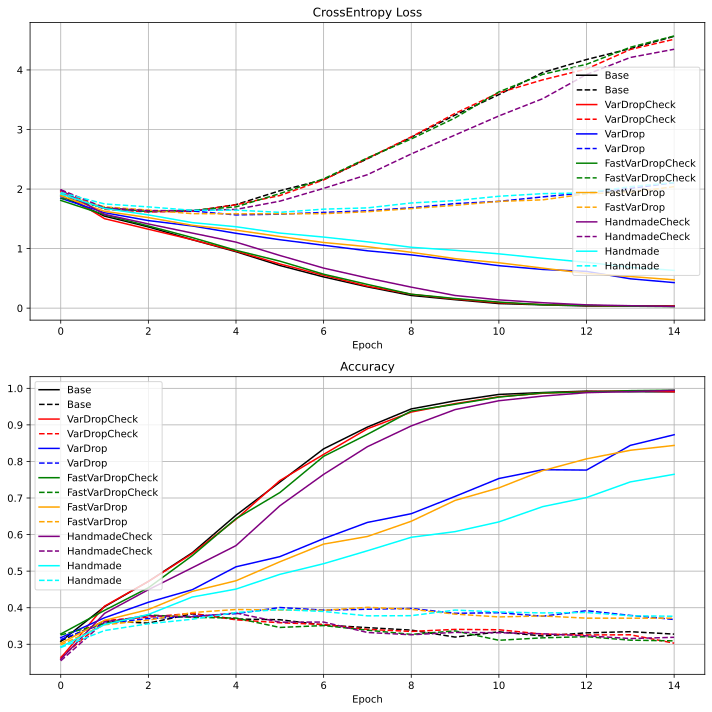

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

color="black"
label="Base"
axes[0].plot([x.cpu() for x in train_losses_pure], label=label, linestyle="-", c=color)
axes[1].plot([x.cpu() for x in train_accuracies_pure], label=label, linestyle="-", c=color)
axes[0].plot([x.cpu() for x in test_losses_pure], label=label, linestyle="--", c=color)
axes[1].plot([x.cpu() for x in test_accuracies_pure], label=label, linestyle="--", c=color)

color="red"
label="VarDrop"
axes[0].plot([x.cpu() for x in train_losses_off_dropout], label=label + "Check", linestyle="-", c=color)
axes[1].plot([x.cpu() for x in train_accuracies_off_dropout], label=label + "Check", linestyle="-", c=color)
axes[0].plot([x.cpu() for x in test_losses_off_dropout], label=label + "Check", linestyle="--", c=color)
axes[1].plot([x.cpu() for x in test_accuracies_off_dropout], label=label + "Check", linestyle="--", c=color)

color="blue"
axes[0].plot([x.cpu() for x in train_losses_25_dropout], label=label, linestyle="-", c=color)
axes[1].plot([x.cpu() for x in train_accuracies_25_dropout], label=label, linestyle="-", c=color)
axes[0].plot([x.cpu() for x in test_losses_25_dropout], label=label, linestyle="--", c=color)
axes[1].plot([x.cpu() for x in test_accuracies_25_dropout], label=label, linestyle="--", c=color)

color="green"
label="FastVarDrop"
axes[0].plot([x.cpu() for x in train_losses_fast_off], label=label + "Check", linestyle="-", c=color)
axes[1].plot([x.cpu() for x in train_accuracies_fast_off], label=label + "Check", linestyle="-", c=color)
axes[0].plot([x.cpu() for x in test_losses_fast_off], label=label + "Check", linestyle="--", c=color)
axes[1].plot([x.cpu() for x in test_accuracies_fast_off], label=label + "Check", linestyle="--", c=color)

color="orange"
axes[0].plot([x.cpu() for x in train_losses_fast_25], label=label, linestyle="-", c=color)
axes[1].plot([x.cpu() for x in train_accuracies_fast_25], label=label, linestyle="-", c=color)
axes[0].plot([x.cpu() for x in test_losses_fast_25], label=label, linestyle="--", c=color)
axes[1].plot([x.cpu() for x in test_accuracies_fast_25], label=label, linestyle="--", c=color)

color="purple"
label="Handmade"
axes[0].plot([x.cpu() for x in train_losses_sem_off], label=label + "Check", linestyle="-", c=color)
axes[1].plot([x.cpu() for x in train_accuracies_sem_off], label=label + "Check", linestyle="-", c=color)
axes[0].plot([x.cpu() for x in test_losses_sem_off], label=label + "Check", linestyle="--", c=color)
axes[1].plot([x.cpu() for x in test_accuracies_sem_off], label=label + "Check", linestyle="--", c=color)

color="cyan"
axes[0].plot([x.cpu() for x in train_losses_sem_25], label=label, linestyle="-", c=color)
axes[1].plot([x.cpu() for x in train_accuracies_sem_25], label=label, linestyle="-", c=color)
axes[0].plot([x.cpu() for x in test_losses_sem_25], label=label, linestyle="--", c=color)
axes[1].plot([x.cpu() for x in test_accuracies_sem_25], label=label, linestyle="--", c=color)


axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')


axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')


fig.tight_layout()
plt.show()

**Вывод:**  Если реализовывать модели с dropout через хак с LSTM, то все реализации работают примерно за одинаковое время. Модель по статье Гала и Гарамани показала себя чуть лучше и постабильнее на наших данных чем модель по Семениуте, но в целом, разница невелика, оба подхода достойны. Дропаут отлично работает как регуляризация и хорошо борется с переобучением. 

# `Часть 2. Language Modeling с помощью LSTM (5 баллов)`

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации — конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## `Реализация модели и цикла обучения (2 балла)`

In [18]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: 
            Batch of texts represented with tokens. Shape: [T, B]
        :param torch.Tensor(dtype=torch.long) tokens_lens: 
            Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.Tensor: 
            Distribution of next token for each time step. Shape: [T, B, V], V — size of vocabulary
        """
        embeddings = self.word_embeddings(tokens)
        
        h, c = self.rnn(embeddings)
        # h has size (T, N, hidden_size)
        
        outputs = self.output(h)  # (T, N, len(vocab))
        return outputs

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [ ]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

`torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [ ]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False).data

tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]])

In [19]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs[:-1], (tokens_lens - 1).cpu(), batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], (tokens_lens - 1).cpu(), batch_first=False, enforce_sorted=False).data
        
        return super().forward(packed_outputs, packed_tokens)

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [20]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: Accuracy for given logits and tokens
        """
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs[:-1], (tokens_lens - 1).cpu(), batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], (tokens_lens - 1).cpu(), batch_first=False, enforce_sorted=False).data
        
        predictions = torch.argmax(packed_outputs, dim=1)
        return (predictions == packed_tokens).float().sum()/len(packed_tokens)

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [21]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        tokens = data["tokens"].to(device)
        tokens_lens = data["tokens_lens"].to(device)

        distrib = model(tokens, tokens_lens)
        loss = loss_fn(distrib, tokens, tokens_lens)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            tokens = data["tokens"].to(device)
            tokens_lens = data["tokens_lens"].to(device)

            tokens_count = tokens_lens.sum() - len(tokens_lens)
            distrib = model(tokens, tokens_lens)
            total_loss += loss_fn(distrib, tokens, tokens_lens) * tokens_count
            total_accuracy += accuracy_fn(distrib, tokens, tokens_lens) * tokens_count
            total_tokens += tokens_count
            
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [22]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
# min_freq=8 is approximately equivalent to max_size=30000. 
lm_vocab = torchtext.vocab.vocab(counter, specials=specials, special_first=True, min_freq=8)
lm_vocab.set_default_index(lm_vocab['<unk>'])

In [23]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [24]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

In [ ]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [  138,  5799,   228,  ...,  2095,   157,  2193],
         [  157, 32479,   191,  ...,  4328,    19,   353],
         ...,
         [  495,     1,   574,  ...,  1376,  2166,  1261],
         [ 1898,  5080,     1,  ...,  4580,  1011,  7859],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20]))

Создадим модель, функцию потерь и оптимизатор: 

In [25]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [26]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [27]:
with warnings.catch_warnings():  # ignore dataloader warnings (num workers)
    warnings.simplefilter("ignore")

    lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
        lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
    )

Epoch: 1/10. Loss (Train/Test): 7.513/7.643. Accuracy (Train/Test): 0.084/0.084
Epoch: 2/10. Loss (Train/Test): 7.288/7.493. Accuracy (Train/Test): 0.094/0.094
Epoch: 3/10. Loss (Train/Test): 7.063/7.369. Accuracy (Train/Test): 0.103/0.102
Epoch: 4/10. Loss (Train/Test): 6.881/7.311. Accuracy (Train/Test): 0.109/0.107
Epoch: 5/10. Loss (Train/Test): 6.694/7.274. Accuracy (Train/Test): 0.112/0.109
Epoch: 6/10. Loss (Train/Test): 6.509/7.253. Accuracy (Train/Test): 0.115/0.111
Epoch: 7/10. Loss (Train/Test): 6.324/7.256. Accuracy (Train/Test): 0.117/0.111
Epoch: 8/10. Loss (Train/Test): 6.178/7.265. Accuracy (Train/Test): 0.123/0.114
Epoch: 9/10. Loss (Train/Test): 6.020/7.285. Accuracy (Train/Test): 0.127/0.114
Epoch: 10/10. Loss (Train/Test): 5.859/7.322. Accuracy (Train/Test): 0.131/0.114


## `Реализация декодера`

Теперь, реализуем последнюю деталь — декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [31]:
@torch.no_grad()
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum lenght of generated samples
    :param Optional[int] top_k: Number of tokens with the largest probability to sample from
    :return Tuple[torch.Tensor, torch.Tensor]. 
        Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    embedding = model.word_embeddings(start_tokens)
    
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        output, (h_t, c_t) = model.rnn(embedding[:time_step + 1], (h, c))
        all_h.append(h_t)
        all_c.append(c_t)

    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    predicted_tokens = []
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        logits = model.output(h[-1])
        
        if top_k is not None:
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = -1e10
            logits = torch.nn.functional.softmax(logits, dim=-1)
            next_token = torch.squeeze(torch.multinomial(logits, 1), dim=-1)
        else:
            next_token = torch.argmax(logits, dim=-1)
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        emb_next_token = model.word_embeddings(next_token)
        # size: (N, emb_size)
        
        output, (h, c) = model.rnn(emb_next_token[None, ...], (h, c))  # 1 cycle in LSTM
        
    return torch.stack(predicted_tokens), decoded_lens

In [7]:
torch.topk(torch.tensor([[1,23,4,5,5], [4,5,6,7,8,]]), 2)[0][..., -1, None]

tensor([[5],
        [7]])

Попробуем сгенерировать продолжения для нескольких префиксов:

In [29]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [32]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [33]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> film begins one worst films ever made plot holes movie <unk> <unk> <unk> <unk> plot line <eos>
<sos> <unk> favorite movie seen movie <unk> <unk> movie good acting great actors great direction good story line <eos>
<sos> <unk> best movie ever seen life movie made first time saw first time saw film thought <eos>
<sos> <unk> worst movie ive ever seen movie ever seen <unk> movie ever seen bad acting good plot <eos>


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

`k == 2`

In [34]:
k = 2
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)

In [35]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> saw movie first time watched movie thought really good movie good acting great story line good movie <eos>
<sos> <unk> favorite movie time <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> movie made one best
<sos> <unk> best movie ever made movie ever made movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> movie <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> worst movie ever made plot holes acting atrocious plot holes <unk> <unk> acting bad script bad special effects <eos>


`k == 10`

In [42]:
k = 10
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)

In [43]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie really good story one liners best actors ever made acting good script good plot twists <unk> <eos>
<sos> <unk> favorite movie ever seen im sorry watching movie first came minutes see one thing watched movie one <eos>
<sos> <unk> best movie ever made movie good actors great actors actresses main characters <unk> <unk> story line <eos>
<sos> <unk> worst movie ever seen bad really bad good actors really nothing else movie nothing else like <unk> <eos>


`k == None`

In [44]:
k = None
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)

In [45]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie really good movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> favorite movie ever seen life <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> best movie ever seen life <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> worst movie ever seen life <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


**Вывод:** Чем меньше k, тем больше токенов '<unk>' мы генерируем. Так получается, потому что этот токен самый частый в данных. Поэтому нужно брать k побольше

## `Beam Search (2 балла)`

Рассмотрим более продвинутый алгоритм для декодирования. Реализуйте алгоритм Beam Search.

Несколько замечаний по имплементации:

1. При больших размерах `beam_size` число гипотез ($B \times \text{beam\_size}$) на очередном шаге может быть слишком большим. Поэтому может потребоваться разбить все гипотезы на отдельные батчи и делать forward-pass в несколько итераций. Используйте [`torch.split`](https://pytorch.org/docs/stable/generated/torch.split.html)
2. Для выбора лучших гипотез используйте [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html). Обратите внимание на индексы, которые возвращает эта функция (может пригодиться метод [`torch.remainder`](https://pytorch.org/docs/stable/generated/torch.remainder.html))
3. Можно отслеживать, какие элементы в батче (или какие гипотезы) закончили генерацию. Делая forward-pass только для незавершённых гипотез, можно ускорить декодинг, однако, это усложнит реализацию

In [35]:
@torch.no_grad()
def decode_beam_search(model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=5):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum length of generated samples
    :param int beam_size: Size of beam
    :return Tuple[torch.Tensor, torch.Tensor, torch.Tensor]. 
        Newly predicted tokens, probabilities for each hypotheses and lengths of generated parts
        Shape [T*, B, beam_size], [B, beam_size], [B, beam_size]
    """
    
    # 1. Initialize beams and hypotheses probabilities for each element in the batch
    # 2. While all sequences do not end with <eos> and their length less than max_generated_len
    #    1. Perform forward pass and obtain probabilities for all extensions
    #    2. Compute probabilities for all hypotheses
    #    3. Select top-beam_size hypotheses for each element in the batch
    #    4. Take tokens that correspond to the chosen hypotheses
    #    5. Concat new tokens to existing prefixes

    embedding = model.word_embeddings(start_tokens)
    
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        output, (h_t, c_t) = model.rnn(embedding[:time_step + 1], (h, c))
        all_h.append(h_t)
        all_c.append(c_t)

    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    beam_h = torch.stack([h.clone() for i in range(beam_size)])  # (beam_size, N, hidden_size)
    beam_c = torch.stack([c.clone() for i in range(beam_size)])  # (beam_size, N, hidden_size)

    hypotheses = None  # tensor with size (N, n_beams, T) (T is current t)
    probs = None  # tensor with size: (N, n_beams)
    #init
    logits = model.output(h[-1])
    logits = torch.nn.functional.softmax(logits, dim=-1)
    topk = torch.topk(logits, beam_size)
    hypotheses = topk[1][..., None]
    probs = topk[0]
    
    for i in range(beam_size):
        h, c = beam_h[i], beam_c[i]
        embeddings = model.word_embeddings(hypotheses[:, i, -1])
        output, (h, c) = model.rnn(embeddings[None, ...], (h, c))
        beam_h[i] = h 
        beam_c[i] = c

    decoded_lens = start_tokens_lens.new_zeros((len(start_tokens_lens), beam_size), dtype=torch.long)
    is_finished_decoding = start_tokens_lens.new_zeros((len(start_tokens_lens), beam_size), dtype=torch.bool)

    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        full_logits = []
        for i in range(beam_size):
            logits = model.output(beam_h[i])
            logits = torch.nn.functional.softmax(logits, dim=-1)
            indices_end = torch.where(~is_finished_decoding[:, i])
            logits = logits * probs[:, i]  # multiply on previous probabilities
            logits[indices_end] = 0
            logits[indices_end, 0] = probs[indices_end, i]
            full_logits.append(logits)
        len_vocab = full_logits[0].shape[-1]
        full_logits = torch.stack(full_logits, dim=-1)
        topk = torch.topk(full_logits, beam_size)
        permute_indices = topk[1] // len_vocab  # size: (N, beam_size)

        beam_h = beam_h[permute_indices]
        beam_c = beam_c[permute_indices]
        hypotheses = beam_c[:, permute_indices]
        probs = topk[0]
        new_tokens = torch.remainder(topk[1], len_vocab)
        hypotheses = torch.cat((hypotheses, new_tokens[..., None]), dim=-1)

        for i in range(beam_size):
            h, c = beam_h[i], beam_c[i]
            embeddings = model.word_embeddings(new_tokens[:, i])
            output, (h, c) = model.rnn(embeddings[None, ...], (h, c))
            beam_h[i] = h 
            beam_c[i] = c

        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= new_tokens == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0])
    
    return torch.permute(hypotheses, (2, 0 ,1)), probs, decoded_lens

Попробуйте выполнить декодинг для разных `beam_size`. Убедитесь, что при `beam_search=1` семплирование совпадает с top-1 (greedy decoding) подходом. 

Сравните результаты Beam Search с top-k семплированием и жадным декодированием. Опишите ваши наблюдения.